# Evoluční algoritmy - Genetické programování

Genetické programování je technika která pomoci evolučních algoritmů vytváří programy. Obecná struktura genetického programování začíná vygenerováním náhodných programů, ohodnocení programů pomocí jejich spuštění na daných datech a vygenerování nové generace programů pomocí klasických evolučních operátorů jako je selekce dle fitness, křížení dvou programů a jejich následná mutace. 

Evoluce obecného kódu je těžká, protože by často vytvářela invalid syntax. Proto se evolvuje jen strojový kód a základní instrukce a práce s registry, jako jsou skoky, základní aritmetické operace apod.

Dneska se podíváme na jednoduché genetické programování, které má dva typy. Lineární, kdy je jedinec zapsán jako posloupnost instrukcí za sebou, a stromové, kdy jsou instrukce uložené ve stromové struktuře. Lineární genetické programování je sice rychlé a operace jsou tam přímočaré, ale obsahuje velké riziko, že vznikne nesmyslný kód. Proto se používá stromové genetické programování, které si vyzkoušíme na problému symbolické regrese, kdy bude naším cílem nalézt vzoreček, který bude nejlépe odpovídat zadaným datům, a následně na příkladu klasifikace kosatců v iris datasetu. Nejprve bude potřeba si rozmyslet, jak zadefinovat jedince jako strom a jak upravit evoluční operátory, aby s nimy uměly pracovat.

K tomuto budeme používat knihovnu deap, kterou jsme si ukázali minule.

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pydot
from pydot import Dot
from IPython.display import Image

import operator
from deap import gp
from deap import creator, base, tools, algorithms

import pydot
from IPython.display import Image

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

Nejprve si vygenerujeme data v nějakém rozumném rozsahu a k nim odpovídající labely, například pomocí funkce sinus. Pro ně pak budeme chtít najít vzoreček regrese, který jim bude nejlépe odpovídat.

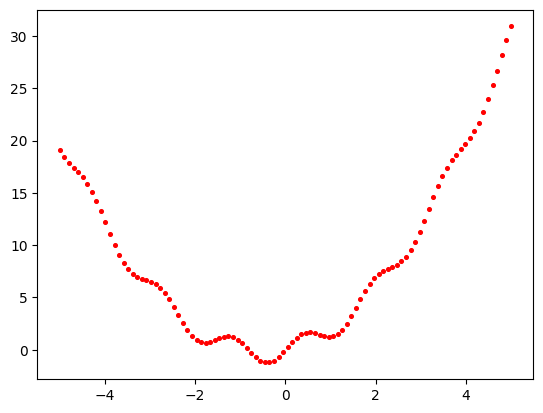

In [21]:
x_train = np.linspace(-5, 5, 100)
y_train = x_train*x_train + x_train + np.sin(4*x_train)

plt.scatter(x_train, y_train,s=7,c='r')
plt.show()

Pro práci s genetickým algoritmem budeme potřebovat definovat jedince. To bude strom, který se bude skládat z množiny terminálů a neterminálů, které si ale musíme předem definovat. K tomu v knihovně deap existuje třída `gp.PrimitiveSet` pro klasické GP, případně `gp.PrimitiveSetTyped` pro typované GP. V našem příkladu použijeme tu typovanou verzi, protože je obecnější. Jelikož ale budeme používat jen jeden typ jedinců, šla by použít i netypovaná verze. Jako terminály si definujeme základní konstanty 0,1,2 a zbytek se dovytvoří z nich během evoluce. Jako neterminály budeme potřebovat operace sčítání, násobení a sinus, a protože zbylé operace se ve vzorečku nevyskytují, nebudeme si jimi zbytečně komplikovat život.

In [22]:
# mnozina se jmenuje MAIN, vstup je jeden float, vystup je taky jeden float
pset = gp.PrimitiveSetTyped('MAIN', [float], float) 

# terminaly
pset.addTerminal(1.0, float)
pset.addTerminal(2.0, float)
pset.addTerminal(0.0, float)


# neterminaly
pset.addPrimitive(np.sin, [float], float)
pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)
#pset.addPrimitive(operator.sub, [float, float], float)
#pset.addPrimitive(np.cos, [float], float)
#pset.addPrimitive(operator.truediv, [float, float], float)

Když máme vytvořené terminály a neterminály, můžeme si definovat jedince, fitness funkci a genetické operátory. Jedince vygenerujeme jako náhodné stromy z množiny primitiv a nastavíme jim počáteční minimální a maximální hloubku. Fitness funkce bude MSE (Mean Squared Error), která počítá střední hodnoty druhých mocnin rozdílů mezi predikovanou výstupní hodnotou a skutečnou výstupní hodnotou, tedy čtvercovou vzdálenost jak daleko je predikovaný výstup od skutečného. Nastavíme jí váhu -1, protože chceme chybu minimalizovat. Zároveň nastavíme i váhu -0.01, která penalizuje počet uzlů ve stromu, abychom evoluci nutili k vytváření spíše menších jedinců. Selekci použijeme turnajovou, křížení jednobodové, kdy se klasicky náhodně zvolí bod a v něm se prohodí části podstromů, a uniformní mutaci, která náhodně vybere místo v jedinci a nahradí podstrom za kořen výrazu vygenerovanou pomocí metody ```expr()``` na základě definovaných operací a konstant. Zároveň přidáme limity na hloubku stromu pri křížení a mutaci, aby nám stromy zbytečně nebobtnaly.

In [23]:
# definujeme fitness 
def fitness(ind, x, y):
    func = toolbox.compile(expr=ind) # vytvorime funkci podle jedince
    vals = list(map(func, x)) # zavolame funkci na data
    return np.sqrt(np.dot(vals-y, vals-y)), len(ind) #spocitame chybu pomoci MSE

# vytvorime tridy pro jedince
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -0.01))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# nastavime algoritmus
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, type_=float, min_=3, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", fitness, x=x_train, y=y_train)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset) 

# limity na hloubku stromu
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

/Users/hugohrban/Documents/pialg/venv/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/hugohrban/Documents/pialg/venv/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Nyní jsme si napsali všechny potřebné operátory a definovali jsme si populaci, tak si ještě dodefinujeme nějaké statistické metody, abychom mohli sledovat vývoj evoluce a pak můžeme náš algoritmus genetického programování pustit.

In [24]:
pop = toolbox.population(n=1000)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 10, stats=mstats, halloffame=hof, verbose=True)

   	      	                       fitness                        	                     size                     
   	      	------------------------------------------------------	----------------------------------------------
gen	nevals	avg    	gen	max        	min    	nevals	std   	avg   	gen	max	min	nevals	std   
0  	1000  	17545.6	0  	1.70057e+07	23.9086	1000  	537575	71.352	0  	814	4  	1000  	121.27
1  	531   	113.8  	1  	2067.36    	9.39668	531   	72.0837	40.615	1  	635	2  	531   	71.5904
2  	591   	103.945	2  	1169.29    	9.39668	591   	46.0275	29.384	2  	481	2  	591   	43.135 
3  	554   	91.1219	3  	840.962    	8.87592	554   	40.1333	30.836	3  	462	2  	554   	38.6415
4  	553   	85.1378	4  	2215.32    	7.03293	553   	94.4642	33.237	4  	250	5  	553   	38.1283
5  	543   	79.2033	5  	2961.95    	7.03293	543   	180.302	32.644	5  	250	3  	543   	39.287 
6  	495   	72.6245	6  	2842.5     	7.03293	495   	194.162	26.854	6  	250	3  	495   	29.553 
7  	569   	89.5593	7  	7430.08    	7.03293

Vidíme, že výstup výše je sice krásný a určitě bohatě vypovídající, ale asi bychom víc ocenili nějakou vizualici. Proto si napíšeme pomocnou funkci na zobrazení vytvořeného stromu. To uděláme pomocí knihovny *pydot*, která slouží právě ke zobrazování grafů.

In [30]:
# zobrazeni jedince jako stromu
import os
os.environ["PATH"] += os.pathsep + "/opt/homebrew/lib/python3.9/site-packages/graphviz"
def plot_tree(tree):
    nodes, edges, labels = gp.graph(tree)
    nodesDot = list(map(lambda x: pydot.Node(x, label=str(labels.get(x))),nodes))

    g = pydot.Dot(graph_type='graph')
    for node in nodesDot:
        g.add_node(node)
    for f,t in edges:
        edge = pydot.Edge(nodesDot[f], nodesDot[t])
        g.add_edge(edge)

    return g.create_png()

In [31]:
Image(plot_tree(hof[0]))

FileNotFoundError: [Errno 2] "dot" not found in path.

Ještě si napíšeme jednoduchou funkci, která nám vykreslí graf, abychom se mohli podívat, jak vypadá naše naučená funkce vzhledem k datům. Když máme štěstí na dobrý běh tak vidíme, že se nám podařilo nalézt funkci téměř ideálně pasující na naše data.

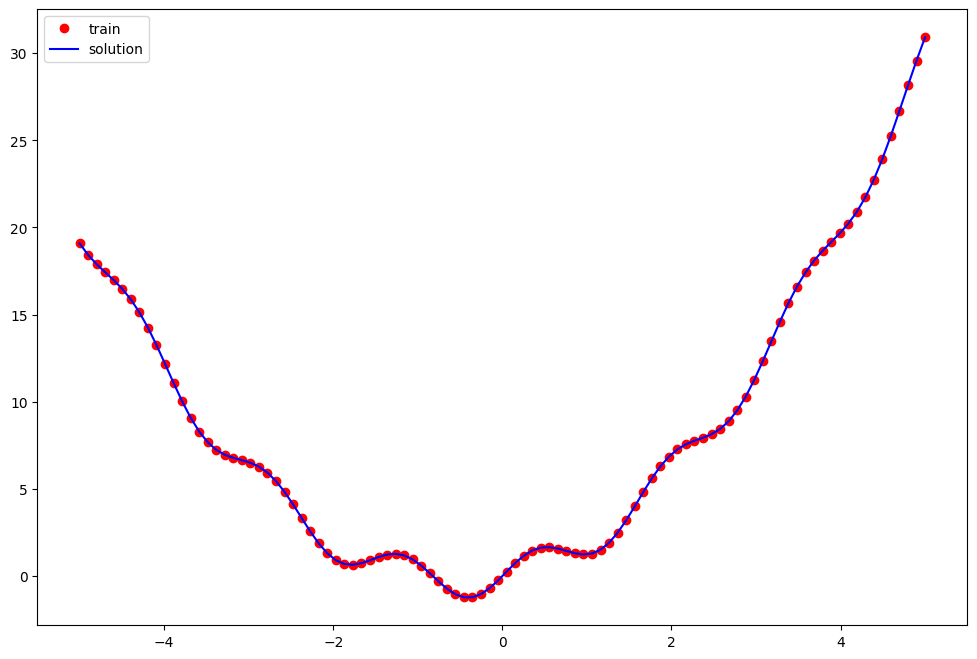

In [27]:
sol = gp.compile(hof[0], pset)

y = list(map(sol, x_train))
plt.figure(figsize=(12, 8))
plt.plot(x_train, y_train, 'ro', label='train')
plt.plot(x_train, y, 'b',label='solution')
plt.legend()
plt.show()

## Úkol na cvičení

Zkuste pomocí genetického programování řešit problém klasifikace pro dataset Iris, se kterým jsme pracovali na prvním cvičení. K tomu bude potřeba si definovat množinu primitiv a fitness. Množina primitiv bude potřebovat minimálně pravidlo pro porovnávání a možnost vygenerovat náhodnou konstantu, aby se mohlo porovnávat nejen mezi vstupy, ale i vstup s nějakou fixní hodnotou, a terminály 0, 1, 2 pro výstupní labely. Fitness může být například accuracy stromu na vstupních datech, kterou pak můžeme v genetickém algoritmu klasicky maximalizovat. Zkuste si rozmyslet další pravidla či prvky, které by se mohly pro tuto úlohu hodit. Následně je naimplementujte je a pusťte genetické programování.

Hint: Dataset si můžete načíst přímo z knihovny *sklearn*, abyste ho nemuseli preprocesovat. Samotné features jsou uložené jako pole v `iris.data` a cílové třídy jsou pak uložené v `iris.target`.

In [9]:
from sklearn import datasets
iris = datasets.load_iris()
features = iris.data
targets = iris.target
print(features[0:10])
print(targets[0:10])


[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]]
[0 0 0 0 0 0 0 0 0 0]


In [ ]:
def ge(a, b, c, d):
   return c if a>=b else d

def lt(a, b, c, d):
    return c if a<b else d

In [ ]:
# def fitness()

In [ ]:
# mnozina se jmenuje MAIN, vstup je jeden float, vystup je taky jeden float
pset = gp.PrimitiveSetTyped('MAIN', [float], float) 

# terminaly
pset.addTerminal(0, int)
pset.addTerminal(1, int)
pset.addTerminal(2, int)
pset.addTerminal(3, int)

pset.addTerminal("class0", str)
pset.addTerminal("class1", str)
pset.addTerminal("class2", str)


# neterminaly
pset.addPrimitive(ge, [float, float, int, int], int)
pset.addPrimitive(lt, [float, float, int, int], int)


creator.create("FitnessMin", base.Fitness, weights=(-1.0, -0.01))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# nastavime algoritmus
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, type_=float, min_=3, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", fitness, x=x_train, y=y_train)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset) 
